# Russian Grappler Dominance Analysis

**Building on findings from the initial exploration and reach analysis...**

This notebook investigates a specific hypothesis: **Are Russian grapplers (wrestlers, sambo fighters, BJJ) more dominant than other fighters?**

The UFC has had a lot of success from Russian fighters like Khabib Nurmagomedov (retired undefeated), Islam Makhachev (current champion), and others who came through the Russian combat sambo and wrestling system. We want to see if the data backs up the idea that this training background gives them an edge.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, ttest_ind, chi2_contingency
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')


## 1. Load and Prepare Data

Same data loading process as the previous notebooks. This time I need to specifically identify Russian fighters and grappling-style fighters.

In [3]:
fighter_attributes = pd.read_csv('data/fighter_attributes.csv')
fighter_history = pd.read_csv('data/fighter_history.csv')
fighter_stats = pd.read_csv('data/fighter_stats.csv')

print(f"Fighter Attributes: {fighter_attributes.shape[0]} fighters")
print(f"Fighter History: {fighter_history.shape[0]} fight records")
print(f"Fighter Stats: {fighter_stats.shape[0]} stat records")
print("")

Fighter Attributes: 3035 fighters
Fighter History: 17837 fight records
Fighter Stats: 34586 stat records



In [4]:
print("Countries in data:")
country_counts = fighter_attributes['country'].value_counts()
print(country_counts.head(20))
print("")
print("Fighting styles:")
style_counts = fighter_attributes['style'].value_counts()
print(style_counts)

Countries in data:
country
usa            1056
brazil          396
canada           76
russia           75
england          70
australia        56
mexico           55
japan            49
poland           38
china            37
france           27
sweden           23
korea            22
ireland          17
argentina        14
germany          13
peru             13
georgia          12
new zealand      12
netherlands      11
Name: count, dtype: int64

Fighting styles:
style
striker                 555
brazilian jiu-jitsu     377
mixed martial artist    211
wrestling               114
freestyle                61
muay thai                37
boxing                   29
kickboxing               28
jiu-jitsu                26
judo                     15
grappling                11
karate                    9
taekwondo                 5
sambo                     5
brawler                   3
kung fu                   3
sanda                     3
thugjitsu                 2
street fighting    

checking what countries and fighting styles we have in the data. 

Categorizing fighters: 

 create 4 categories: Russian Grappler, Russian Non-Grappler, Non-Russian Grappler, Non-Russian Non-Grappler.

In [5]:
grappling_styles_list = ['wrestling', 'brazilian jiu-jitsu', 'grappling', 'sambo', 'judo', 'catch wrestling']

fighter_attributes['is_grappler'] = fighter_attributes['style'].str.lower().isin(grappling_styles_list)

fighter_attributes['is_russian'] = fighter_attributes['country'].str.lower() == 'russia'

def categorize_fighter(row):
    if row['is_russian'] and row['is_grappler']:
        return 'Russian Grappler'
    elif row['is_russian'] and not row['is_grappler']:
        return 'Russian Non-Grappler'
    elif not row['is_russian'] and row['is_grappler']:
        return 'Non-Russian Grappler'
    else:
        return 'Non-Russian Non-Grappler'

fighter_attributes['fighter_category'] = fighter_attributes.apply(categorize_fighter, axis=1)

print("Fighter Categories:")
category_counts = fighter_attributes['fighter_category'].value_counts()
print(category_counts)

Fighter Categories:
fighter_category
Non-Russian Non-Grappler    2457
Non-Russian Grappler         503
Russian Non-Grappler          56
Russian Grappler              19
Name: count, dtype: int64


win/loss records for each fighter. 

In [6]:
records = fighter_history.groupby('fighter_id').agg({
    'fight_result': [
        lambda x: (x == 'W').sum(),
        lambda x: (x == 'L').sum(),
        'count'
    ],
    'fighter_name': 'first'
})
records.columns = ['wins', 'losses', 'total_fights', 'fighter_name']
records['win_rate'] = records['wins'] / records['total_fights']
records = records.reset_index()

win_methods = fighter_history[fighter_history['fight_result'] == 'W'].groupby('fighter_id')['fight_result_type'].value_counts().unstack(fill_value=0)
win_methods = win_methods.reset_index()

print("Fighters with records:", len(records))
print("")
records.head()

Fighters with records: 3015



,fighter_id,wins,losses,total_fights,fighter_name,win_rate
0,2220951,6,5,12,greg hardy,0.500000
1,2223033,2,5,8,austen lane,0.250000
2,2312150,5,2,7,mohammed usman,0.714286
3,2335243,9,10,19,carlos condit,0.473684
4,2335256,1,3,4,carmelo marrero,0.250000


In [8]:
stats_agg = fighter_stats.groupby('fighter_id').agg({
    'TDL': 'sum',
    'TDA': 'sum',
    'TSL': 'sum',
    'TSA': 'sum',
    'SSL': 'sum',
    'SSA': 'sum',
    'KD': 'sum',
    'SGBL': 'sum',
    'SGHL': 'sum',
    'SM': 'sum',
    'AD': 'sum',
    'RV': 'sum',
})

stats_agg = stats_agg.reset_index()

stats_agg['takedown_accuracy'] = stats_agg['TDL'] / stats_agg['TDA']
stats_agg['ground_strikes'] = stats_agg['SGBL'] + stats_agg['SGHL']

stats_agg.head()

,fighter_id,TDL,TDA,TSL,TSA,SSL,SSA,KD,SGBL,SGHL,SM,AD,RV,takedown_accuracy,ground_strikes
0,2220951,1,3,398,757,363,721,3,3,71,0,1,0,0.333333,74
1,2223033,4,14,199,342,108,212,1,3,24,0,0,1,0.285714,27
2,2312150,3,21,416,940,310,791,1,0,6,0,0,0,0.142857,6
3,2335243,9,22,1723,3316,969,2496,6,8,116,11,27,9,0.409091,124
4,2335256,6,15,97,157,27,83,0,10,8,0,5,0,0.400000,18


In [9]:
df = fighter_attributes.merge(records, on='fighter_id', how='inner')
df = df.merge(stats_agg, on='fighter_id', how='left')
df = df.merge(win_methods, on='fighter_id', how='left')

win_type_columns = [col for col in df.columns if col in ['DEC-UNA', 'DEC-SPL', 'DEC-MAJ', 'KO-TKO', 'SUBMISSION', 'DQ']]
for col in win_type_columns:
    df[col] = df[col].fillna(0)

MIN_FIGHTS = 3
df_analysis = df[df['total_fights'] >= MIN_FIGHTS]
df_analysis = df_analysis.copy()

df_analysis['takedowns_per_fight'] = df_analysis['TDL'] / df_analysis['total_fights']
df_analysis['ground_strikes_per_fight'] = df_analysis['ground_strikes'] / df_analysis['total_fights']
df_analysis['submissions_per_fight'] = df_analysis['SM'] / df_analysis['total_fights']

print("Fighters for analysis (min", MIN_FIGHTS, "fights):", len(df_analysis))
print("")
print("Fighter Categories in analysis:")
print(df_analysis['fighter_category'].value_counts())

Fighters for analysis (min 3 fights): 1904

Fighter Categories in analysis:
fighter_category
Non-Russian Non-Grappler    1416
Non-Russian Grappler         430
Russian Non-Grappler          40
Russian Grappler              18
Name: count, dtype: int64


Looking at just the Russian fighters to understand the sample better. How many are grapplers vs strikers?

## 2. Russian Fighters Overview

In [10]:
russians = df_analysis[df_analysis['is_russian'] == True]

print("Total Russian fighters (min", MIN_FIGHTS, "fights):", len(russians))
print("")
print("Russian fighters by style:")
russian_styles = russians['style'].value_counts()
print(russian_styles)
print("")
num_grappler = russians['is_grappler'].sum()
num_non_grappler = (~russians['is_grappler']).sum()
print("Russian grapplers:", num_grappler)
print("Russian non-grapplers:", num_non_grappler)

Total Russian fighters (min 3 fights): 58

Russian fighters by style:
style
striker                 21
brazilian jiu-jitsu      9
mixed martial artist     7
wrestling                6
sambo                    2
freestyle                1
karate                   1
grappling                1
Name: count, dtype: int64

Russian grapplers: 18
Russian non-grapplers: 40


Let me see who the top Russian fighters are:

In [11]:
top_russians_by_wins = russians.nlargest(15, 'wins')
cols_to_show = ['name', 'style', 'wins', 'losses', 'win_rate', 'total_fights']
print("Top 15 Russian Fighters by Wins:")
print("=" * 60)
top_russians_by_wins[cols_to_show]

Top 15 Russian Fighters by Wins:


,name,style,wins,losses,win_rate,total_fights
0,Islam Makhachev,wrestling,16,1,0.941176,17
1897,Khabib Nurmagomedov,wrestling,13,0,1.000000,13
333,Magomed Ankalaev,striker,12,1,0.800000,15
395,Alexander Volkov,striker,12,5,0.705882,17
820,Nikita Krylov,brazilian jiu-jitsu,11,9,0.550000,20
922,Petr Yan,striker,11,4,0.733333,15
1588,Rustam Khabilov,NaN,10,3,0.769231,13
403,Muslim Salikhov,striker,9,4,0.692308,13
626,Movsar Evloev,freestyle,9,0,1.000000,9
826,Aleksei Oleinik,brazilian jiu-jitsu,9,8,0.529412,17


Pie charts to show the style breakdown. Pie charts are good for showing parts of a whole.

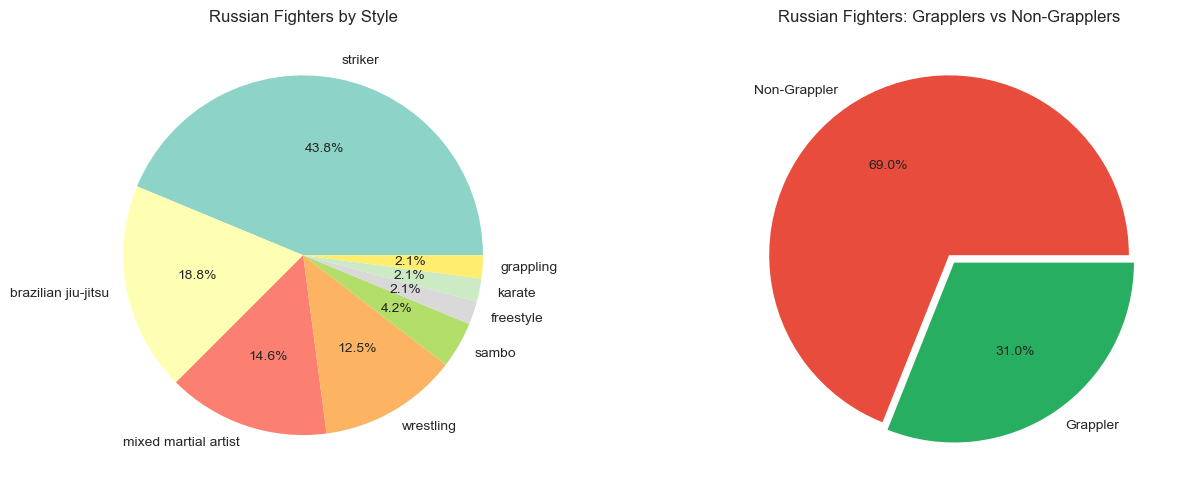

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

styles = russians['style'].value_counts()
num_styles = len(styles)
color_palette = plt.cm.Set3(np.linspace(0, 1, num_styles))
axes[0].pie(styles.values, labels=styles.index, autopct='%1.1f%%', colors=color_palette)
axes[0].set_title('Russian Fighters by Style')

grappler_or_not = russians['is_grappler'].value_counts()
labels_list = ['Non-Grappler', 'Grappler']
axes[1].pie(grappler_or_not.values, labels=labels_list, autopct='%1.1f%%', 
            colors=['#e74c3c', '#27ae60'], explode=[0, 0.05])
axes[1].set_title('Russian Fighters: Grapplers vs Non-Grapplers')

plt.tight_layout()
plt.show()

Seems like grappling is nt as dominant as I would have thought. But Russia is big and there are a lot of fighters, it may be that the grapplers/wrestlers that do come out of Russia are just that elite.

## 3. Win Rate Comparison: Russian Grapplers vs Everyone Else

do Russian grapplers actually have higher win rates?

In [13]:
stats_by_category = df_analysis.groupby('fighter_category').agg({
    'win_rate': ['mean', 'std', 'count'],
    'wins': 'sum',
    'losses': 'sum',
    'total_fights': 'sum'
})

stats_by_category = stats_by_category.round(4)
stats_by_category.columns = ['avg_win_rate', 'std_win_rate', 'n_fighters', 'total_wins', 'total_losses', 'total_fights']
stats_by_category['overall_win_rate'] = stats_by_category['total_wins'] / stats_by_category['total_fights']

print("Win Rate Statistics by Fighter Category:")
print("=" * 60)
stats_by_category

Win Rate Statistics by Fighter Category:


,avg_win_rate,std_win_rate,n_fighters,total_wins,total_losses,total_fights,overall_win_rate
fighter_category,,,,,,,
Non-Russian Grappler,0.4966,0.1941,430,2557,2058,4710,0.542887
Non-Russian Non-Grappler,0.4559,0.2269,1416,5720,5250,11159,0.512591
Russian Grappler,0.5910,0.2612,18,98,53,152,0.644737
Russian Non-Grappler,0.5987,0.2433,40,185,98,292,0.633562


Bar chart with error bars to visualize this. The error bars show standard error which helps us see the uncertainty. I'll add a horizontal line for the overall mean to make it easy to see who's above/below average.

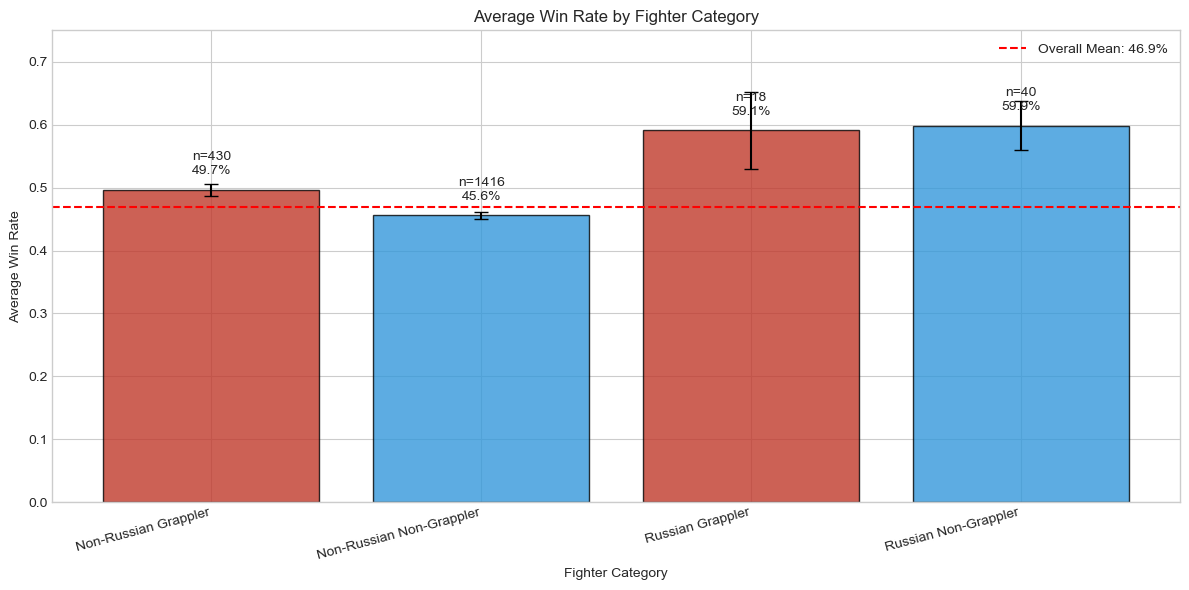

In [15]:
fig, ax = plt.subplots(figsize=(12, 6))

cat_names = stats_by_category.index.tolist()
avg_wr = stats_by_category['avg_win_rate'].values
std_wr = stats_by_category['std_win_rate'].values
n_fighters = stats_by_category['n_fighters'].values

se = std_wr / np.sqrt(n_fighters)

bar_colors = []
for cat in cat_names:
    if 'Russian Grappler' in cat:
        bar_colors.append('#c0392b')
    elif 'Russian' in cat:
        bar_colors.append('#3498db')
    else:
        bar_colors.append('#95a5a6')

bars = ax.bar(cat_names, avg_wr, yerr=se, capsize=5, color=bar_colors, edgecolor='black', alpha=0.8)

for bar, n, rate in zip(bars, n_fighters, avg_wr):
    x = bar.get_x() + bar.get_width()/2
    y = bar.get_height() + 0.02
    ax.text(x, y, f'n={n}\n{rate:.1%}', ha='center', va='bottom', fontsize=10)

ax.set_title('Average Win Rate by Fighter Category')
ax.set_xlabel('Fighter Category')
ax.set_ylabel('Average Win Rate')
ax.set_ylim(0, 0.75)
mean_all = df_analysis['win_rate'].mean()
ax.axhline(mean_all, color='red', linestyle='--', 
           label='Overall Mean: ' + str(round(mean_all*100, 1)) + '%')
ax.legend()
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

Now for statistical testing. Using t-tests from scipy to check if the differences are statistically significant. Just like we did in the reach analysis.

In [16]:
russian_grapplers_wr = df_analysis[df_analysis['fighter_category'] == 'Russian Grappler']['win_rate']
non_russian_grapplers_wr = df_analysis[df_analysis['fighter_category'] == 'Non-Russian Grappler']['win_rate']
all_others_wr = df_analysis[df_analysis['fighter_category'] != 'Russian Grappler']['win_rate']

t_stat_1, p_val_1 = ttest_ind(russian_grapplers_wr, all_others_wr)

t_stat_2, p_val_2 = ttest_ind(russian_grapplers_wr, non_russian_grapplers_wr)

print("STATISTICAL SIGNIFICANCE TESTS")
print("=" * 60)
print()
print("1. Russian Grapplers vs ALL Others:")
print("   Russian Grapplers Mean:", round(russian_grapplers_wr.mean(), 4), "(n=" + str(len(russian_grapplers_wr)) + ")")
print("   All Others Mean:", round(all_others_wr.mean(), 4), "(n=" + str(len(all_others_wr)) + ")")
diff1 = russian_grapplers_wr.mean() - all_others_wr.mean()
print("   Difference:", round(diff1, 4))
print("   T-statistic:", round(t_stat_1, 4))
print("   P-value:", round(p_val_1, 4))
if p_val_1 < 0.05:
    print("   Significant at alpha=0.05? YES")
else:
    print("   Significant at alpha=0.05? NO")

print()
print("2. Russian Grapplers vs Non-Russian Grapplers:")
print("   Russian Grapplers Mean:", round(russian_grapplers_wr.mean(), 4), "(n=" + str(len(russian_grapplers_wr)) + ")")
print("   Non-Russian Grapplers Mean:", round(non_russian_grapplers_wr.mean(), 4), "(n=" + str(len(non_russian_grapplers_wr)) + ")")
diff2 = russian_grapplers_wr.mean() - non_russian_grapplers_wr.mean()
print("   Difference:", round(diff2, 4))
print("   T-statistic:", round(t_stat_2, 4))
print("   P-value:", round(p_val_2, 4))
if p_val_2 < 0.05:
    print("   Significant at alpha=0.05? YES")
else:
    print("   Significant at alpha=0.05? NO")

STATISTICAL SIGNIFICANCE TESTS

1. Russian Grapplers vs ALL Others:
   Russian Grapplers Mean: 0.591 (n=18)
   All Others Mean: 0.4682 (n=1886)
   Difference: 0.1227
   T-statistic: 2.3349
   P-value: 0.0197
   Significant at alpha=0.05? YES

2. Russian Grapplers vs Non-Russian Grapplers:
   Russian Grapplers Mean: 0.591 (n=18)
   Non-Russian Grapplers Mean: 0.4966 (n=430)
   Difference: 0.0944
   T-statistic: 1.9904
   P-value: 0.0472
   Significant at alpha=0.05? YES


## 4. How Do Russian Grapplers Win?

Beyond just win rate, I want to know HOW they win. Are they submitting people? Going to decision? Knockouts? This could tell us something about their fighting style and approach.

In [17]:
win_type_cols_list = ['DEC-UNA', 'DEC-SPL', 'DEC-MAJ', 'KO-TKO', 'SUBMISSION']
cols_available = [col for col in win_type_cols_list if col in df_analysis.columns]

win_types_by_cat = df_analysis.groupby('fighter_category')[cols_available].sum()
win_types_by_cat['Total_Wins'] = win_types_by_cat.sum(axis=1)

win_type_percentages = win_types_by_cat[cols_available].div(win_types_by_cat['Total_Wins'], axis=0) * 100

print("Win Type Distribution by Category (%)")
print("=" * 60)
win_type_percentages.round(1)

Win Type Distribution by Category (%)


,DEC-UNA,DEC-MAJ,KO-TKO,SUBMISSION
fighter_category,,,,
Non-Russian Grappler,39.7,0.7,27.6,32.0
Non-Russian Non-Grappler,40.8,0.9,40.0,18.3
Russian Grappler,36.3,0.0,25.3,38.5
Russian Non-Grappler,51.2,0.6,38.8,9.4


Stacked bar chart to visualize win types. Makes it easy to compare the composition across categories.

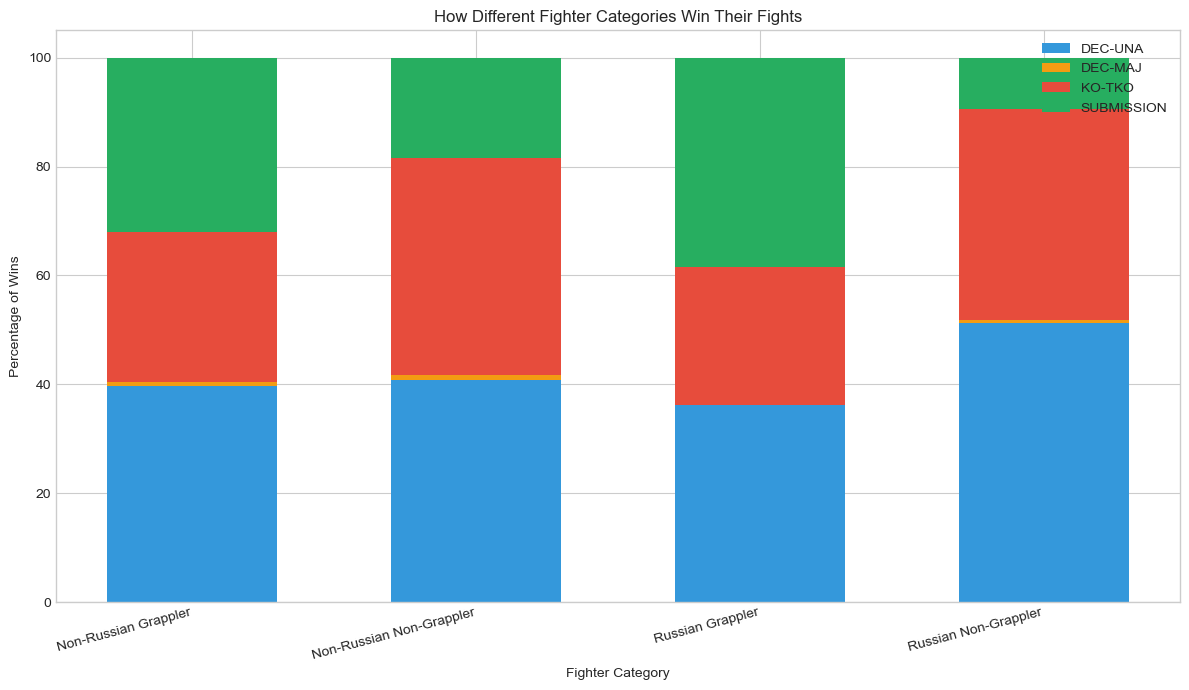

In [18]:
fig, ax = plt.subplots(figsize=(12, 7))

cat_list = win_type_percentages.index.tolist()
x_pos = np.arange(len(cat_list))
bar_width = 0.6

color_map = {'SUBMISSION': '#27ae60', 'KO-TKO': '#e74c3c', 'DEC-UNA': '#3498db', 
             'DEC-SPL': '#9b59b6', 'DEC-MAJ': '#f39c12'}

bottom_vals = np.zeros(len(cat_list))
for col in cols_available:
    vals = win_type_percentages[col].values
    color = color_map.get(col, 'gray')
    ax.bar(x_pos, vals, bar_width, label=col, bottom=bottom_vals, color=color)
    bottom_vals += vals

ax.set_xlabel('Fighter Category')
ax.set_ylabel('Percentage of Wins')
ax.set_title('How Different Fighter Categories Win Their Fights')
ax.set_xticks(x_pos)
ax.set_xticklabels(cat_list, rotation=15, ha='right')
ax.legend(loc='upper right')
ax.set_ylim(0, 105)

plt.tight_layout()
plt.show()

Submission rate specifically, what percent of wins are by submission. This should be higher for grapplers since that's their specialty.

In [19]:
if 'SUBMISSION' in df_analysis.columns:
    df_analysis['submission_rate'] = df_analysis['SUBMISSION'] / df_analysis['wins']
    df_analysis['submission_rate'] = df_analysis['submission_rate'].fillna(0)
    
    sub_rates = df_analysis.groupby('fighter_category')['submission_rate'].agg(['mean', 'std', 'count'])
    print("Submission Rate (% of wins by submission):")
    print("=" * 50)
    print(sub_rates.round(4))

Submission Rate (% of wins by submission):
                            mean     std  count
fighter_category                               
Non-Russian Grappler      0.2893  0.3027    430
Non-Russian Non-Grappler  0.1658  0.2773   1416
Russian Grappler          0.3167  0.3401     18
Russian Non-Grappler      0.1090  0.2540     40


## 5. Grappling Statistics Comparison

Now let's look at actual grappling metrics: takedowns, ground control, submission attempts. If Russian grapplers are really better, they should show it in these stats.

In [20]:
grappling_metrics = df_analysis.groupby('fighter_category').agg({
    'takedowns_per_fight': 'mean',
    'takedown_accuracy': 'mean',
    'ground_strikes_per_fight': 'mean',
    'submissions_per_fight': 'mean',
    'TDL': 'sum',
    'TDA': 'sum'
})

grappling_metrics = grappling_metrics.round(3)
grappling_metrics['overall_td_accuracy'] = grappling_metrics['TDL'] / grappling_metrics['TDA']

print("Grappling Statistics by Fighter Category:")
print("=" * 60)
grappling_metrics

Grappling Statistics by Fighter Category:


,takedowns_per_fight,takedown_accuracy,ground_strikes_per_fight,submissions_per_fight,TDL,TDA,overall_td_accuracy
fighter_category,,,,,,,
Non-Russian Grappler,1.279,0.365,5.206,0.525,4493.0,12463.0,0.360507
Non-Russian Non-Grappler,0.928,0.388,4.276,0.326,7792.0,20217.0,0.385418
Russian Grappler,1.529,0.357,5.167,0.381,203.0,512.0,0.396484
Russian Non-Grappler,1.141,0.377,4.920,0.120,275.0,684.0,0.402047


Four subplots to show different grappling metrics. Subplots are useful when you want to compare multiple related things at once.

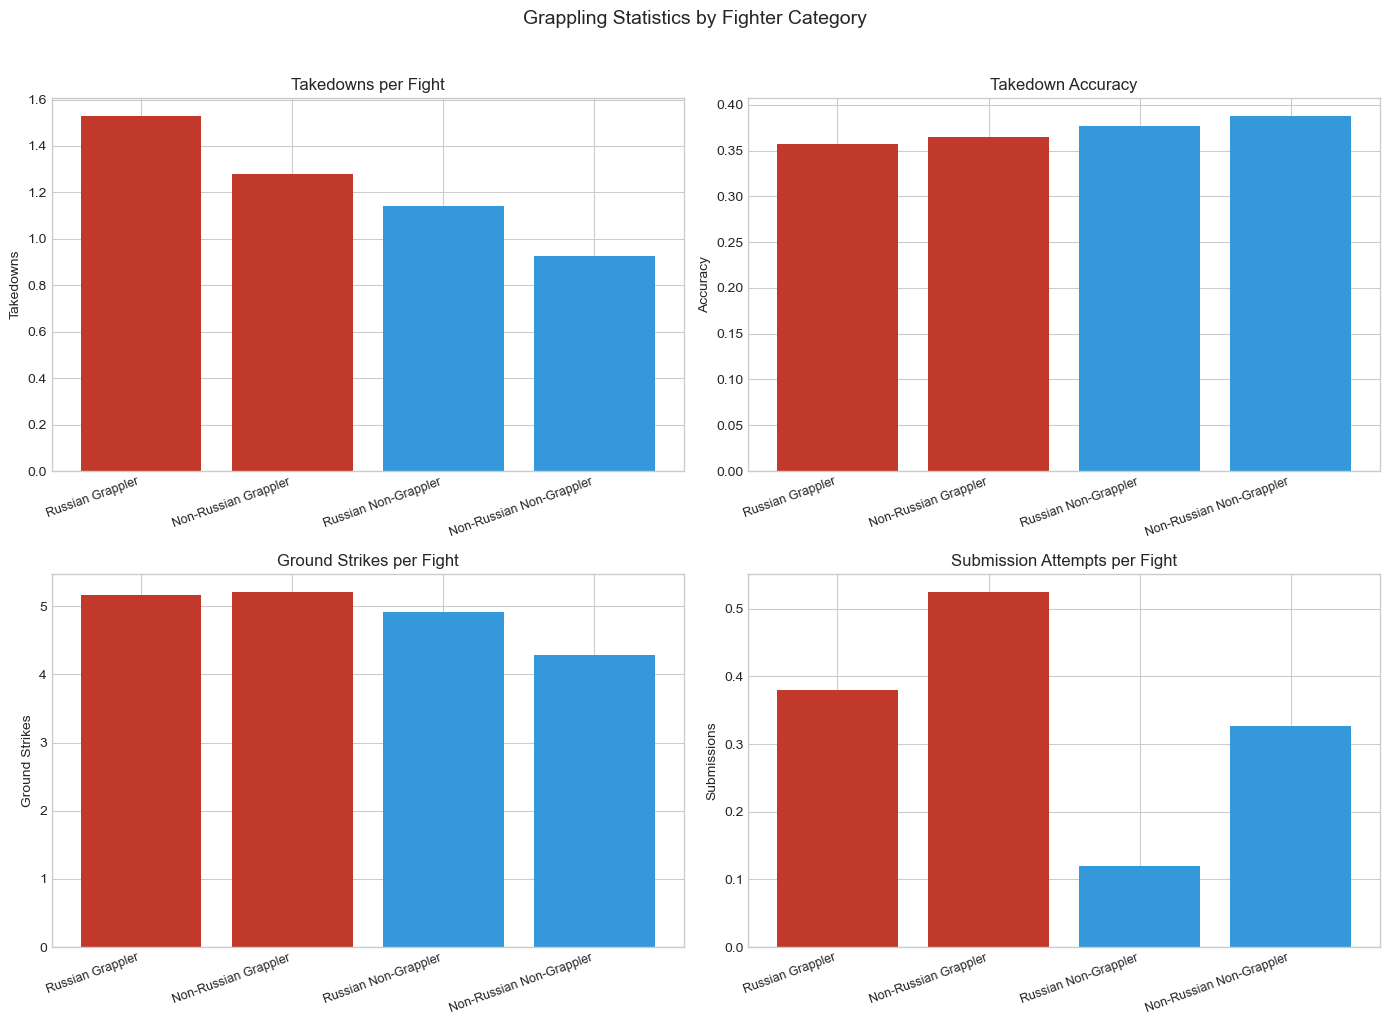

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

all_categories = df_analysis['fighter_category'].unique()
category_order = ['Russian Grappler', 'Non-Russian Grappler', 'Russian Non-Grappler', 'Non-Russian Non-Grappler']
category_order = [c for c in category_order if c in all_categories]

bar_colors_list = []
for cat in category_order:
    if 'Russian Grappler' in cat:
        bar_colors_list.append('#c0392b')
    elif 'Russian' in cat:
        bar_colors_list.append('#3498db')
    else:
        bar_colors_list.append('#95a5a6')

td_pf = df_analysis.groupby('fighter_category')['takedowns_per_fight'].mean().reindex(category_order)
axes[0, 0].bar(range(len(category_order)), td_pf.values, color=bar_colors_list)
axes[0, 0].set_xticks(range(len(category_order)))
axes[0, 0].set_xticklabels(category_order, rotation=20, ha='right', fontsize=9)
axes[0, 0].set_title('Takedowns per Fight')
axes[0, 0].set_ylabel('Takedowns')

td_acc = df_analysis.groupby('fighter_category')['takedown_accuracy'].mean().reindex(category_order)
axes[0, 1].bar(range(len(category_order)), td_acc.values, color=bar_colors_list)
axes[0, 1].set_xticks(range(len(category_order)))
axes[0, 1].set_xticklabels(category_order, rotation=20, ha='right', fontsize=9)
axes[0, 1].set_title('Takedown Accuracy')
axes[0, 1].set_ylabel('Accuracy')

gs_pf = df_analysis.groupby('fighter_category')['ground_strikes_per_fight'].mean().reindex(category_order)
axes[1, 0].bar(range(len(category_order)), gs_pf.values, color=bar_colors_list)
axes[1, 0].set_xticks(range(len(category_order)))
axes[1, 0].set_xticklabels(category_order, rotation=20, ha='right', fontsize=9)
axes[1, 0].set_title('Ground Strikes per Fight')
axes[1, 0].set_ylabel('Ground Strikes')

subs_pf = df_analysis.groupby('fighter_category')['submissions_per_fight'].mean().reindex(category_order)
axes[1, 1].bar(range(len(category_order)), subs_pf.values, color=bar_colors_list)
axes[1, 1].set_xticks(range(len(category_order)))
axes[1, 1].set_xticklabels(category_order, rotation=20, ha='right', fontsize=9)
axes[1, 1].set_title('Submission Attempts per Fight')
axes[1, 1].set_ylabel('Submissions')

plt.suptitle('Grappling Statistics by Fighter Category', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

Russian Grapplers appear to have more takedowns per fight compared to other grapplers but they do have slightly less accuracy 

## 6. Country Comparison: Grapplers by Nation

Let me zoom out and compare grapplers from different countries, not just Russia. Maybe there are other countries with dominant grapplers too like Brazil or USA.

In [22]:
only_grapplers = df_analysis[df_analysis['is_grappler'] == True]
only_grapplers = only_grapplers.copy()

country_fighter_counts = only_grapplers['country'].value_counts()
countries_with_enough = country_fighter_counts[country_fighter_counts >= 5].index.tolist()

grapplers_filtered = only_grapplers[only_grapplers['country'].isin(countries_with_enough)]
grapplers_by_nation = grapplers_filtered.groupby('country').agg({
    'win_rate': 'mean',
    'fighter_id': 'count',
    'wins': 'sum',
    'losses': 'sum',
    'takedowns_per_fight': 'mean'
})

grapplers_by_nation = grapplers_by_nation.rename(columns={'fighter_id': 'n_fighters'})
grapplers_by_nation['overall_record'] = grapplers_by_nation.apply(
    lambda x: str(int(x['wins'])) + "-" + str(int(x['losses'])), axis=1)
grapplers_by_nation = grapplers_by_nation.sort_values('win_rate', ascending=False)

print("Grapplers by Country (min 5 fighters):")
print("=" * 60)
grapplers_by_nation.round(3)

Grapplers by Country (min 5 fighters):


,win_rate,n_fighters,wins,losses,takedowns_per_fight,overall_record
country,,,,,,
poland,0.625,5,31,19,2.030,31-19
russia,0.591,18,98,53,1.529,98-53
brazil,0.515,102,606,462,1.220,606-462
usa,0.500,207,1419,1095,1.333,1419-1095
england,0.491,10,42,37,1.940,42-37
canada,0.490,11,63,60,0.996,63-60
mexico,0.457,8,37,35,0.949,37-35
australia,0.419,7,27,32,1.136,27-32
japan,0.410,10,29,44,0.578,29-44


Horizontal bar chart works well when you have many categories. I'll highlight Russia in red.

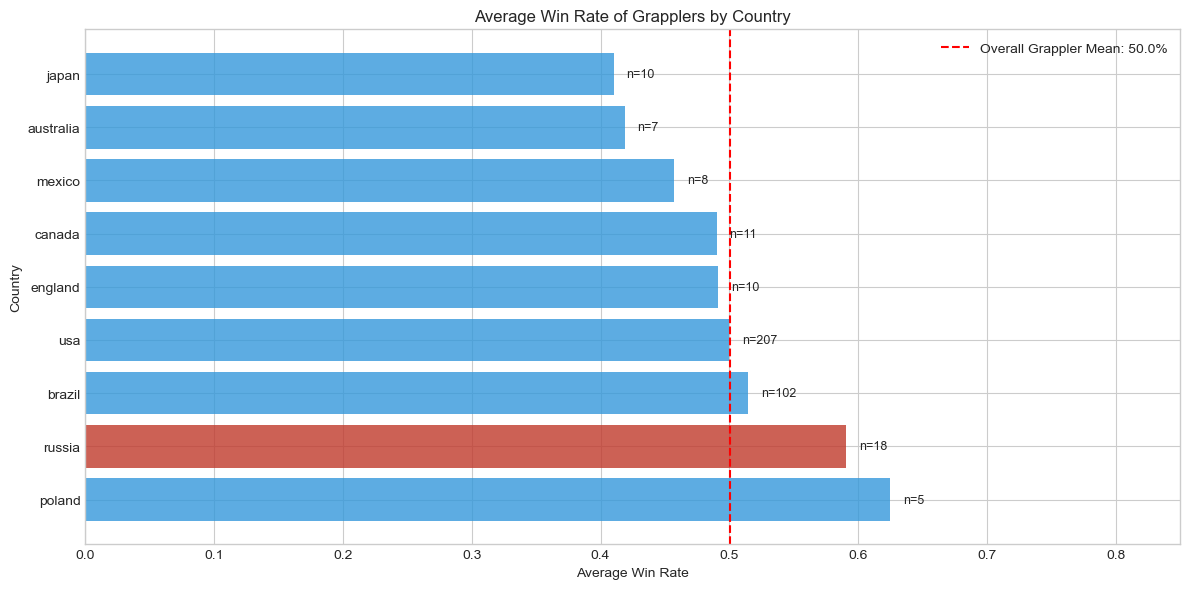

In [23]:
fig, ax = plt.subplots(figsize=(12, 6))

nation_names = grapplers_by_nation.index.tolist()
nation_win_rates = grapplers_by_nation['win_rate'].values
nation_counts = grapplers_by_nation['n_fighters'].values

bar_colors_nations = []
for nation in nation_names:
    if nation == 'russia':
        bar_colors_nations.append('#c0392b')
    else:
        bar_colors_nations.append('#3498db')

bars = ax.barh(nation_names, nation_win_rates, color=bar_colors_nations, alpha=0.8)

for bar, count in zip(bars, nation_counts):
    width = bar.get_width()
    y_pos = bar.get_y() + bar.get_height()/2
    ax.text(width + 0.01, y_pos, 'n=' + str(count), ha='left', va='center', fontsize=9)

ax.set_xlabel('Average Win Rate')
ax.set_ylabel('Country')
ax.set_title('Average Win Rate of Grapplers by Country')
grappler_mean = only_grapplers['win_rate'].mean()
ax.axvline(grappler_mean, color='red', linestyle='--', 
           label='Overall Grappler Mean: ' + str(round(grappler_mean*100, 1)) + '%')
ax.legend()
ax.set_xlim(0, 0.85)

plt.tight_layout()
plt.show()

## 7. Win Rate Distribution Comparison

Looking at just the mean can be misleading.

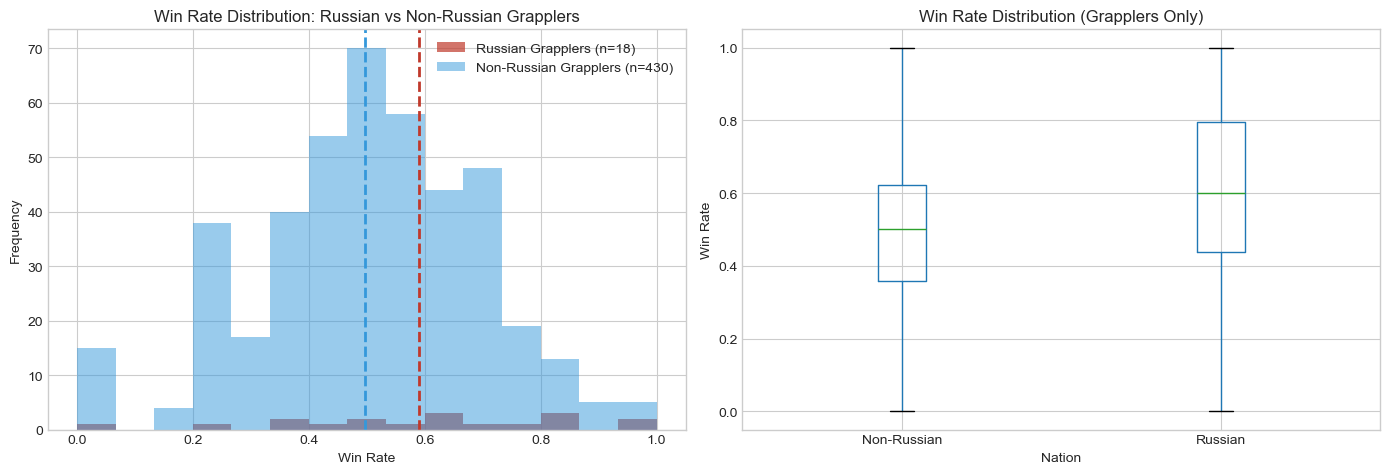

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

n_rg = len(russian_grapplers_wr)
n_nrg = len(non_russian_grapplers_wr)
axes[0].hist(russian_grapplers_wr, bins=15, alpha=0.7, label='Russian Grapplers (n=' + str(n_rg) + ')', color='#c0392b')
axes[0].hist(non_russian_grapplers_wr, bins=15, alpha=0.5, label='Non-Russian Grapplers (n=' + str(n_nrg) + ')', color='#3498db')
axes[0].axvline(russian_grapplers_wr.mean(), color='#c0392b', linestyle='--', linewidth=2)
axes[0].axvline(non_russian_grapplers_wr.mean(), color='#3498db', linestyle='--', linewidth=2)
axes[0].set_xlabel('Win Rate')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Win Rate Distribution: Russian vs Non-Russian Grapplers')
axes[0].legend()

grapplers_only = df_analysis[df_analysis['is_grappler'] == True]
grapplers_only = grapplers_only.copy()
grapplers_only['nation_type'] = grapplers_only['is_russian'].map({True: 'Russian', False: 'Non-Russian'})
grapplers_only.boxplot(column='win_rate', by='nation_type', ax=axes[1])
axes[1].set_xlabel('Nation')
axes[1].set_ylabel('Win Rate')
axes[1].set_title('Win Rate Distribution (Grapplers Only)')
plt.suptitle('')

plt.tight_layout()
plt.show()

## 8. Elite Fighter Analysis (High Win Rate)

Who are the "elite" fighters? I will define elite as 70%+ win rate with at least 5 fights. Then see which category produces the most elite fighters.

In [26]:
MIN_FIGHTS_ELITE = 5
ELITE_WIN_RATE = 0.7

elite_fighters = df_analysis[(df_analysis['total_fights'] >= MIN_FIGHTS_ELITE) & 
                              (df_analysis['win_rate'] >= ELITE_WIN_RATE)]
elite_fighters = elite_fighters.copy()

print("Elite Fighters (>= 70% win rate, >= 5 fights):", len(elite_fighters))
print("")
print("Elite fighters by category:")
elite_cat_counts = elite_fighters['fighter_category'].value_counts()
print(elite_cat_counts)

total_cat_counts = df_analysis[df_analysis['total_fights'] >= MIN_FIGHTS_ELITE]['fighter_category'].value_counts()
elite_percentages = (elite_cat_counts / total_cat_counts * 100)
elite_percentages = elite_percentages.round(1)
print("")
print("Percentage of category that is elite:")
print(elite_percentages)

Elite Fighters (>= 70% win rate, >= 5 fights): 218

Elite fighters by category:
fighter_category
Non-Russian Non-Grappler    151
Non-Russian Grappler         50
Russian Non-Grappler         11
Russian Grappler              6
Name: count, dtype: int64

Percentage of category that is elite:
fighter_category
Non-Russian Non-Grappler    16.4
Non-Russian Grappler        14.7
Russian Non-Grappler        39.3
Russian Grappler            42.9
Name: count, dtype: float64


Bar chart to visualize elite percentages:

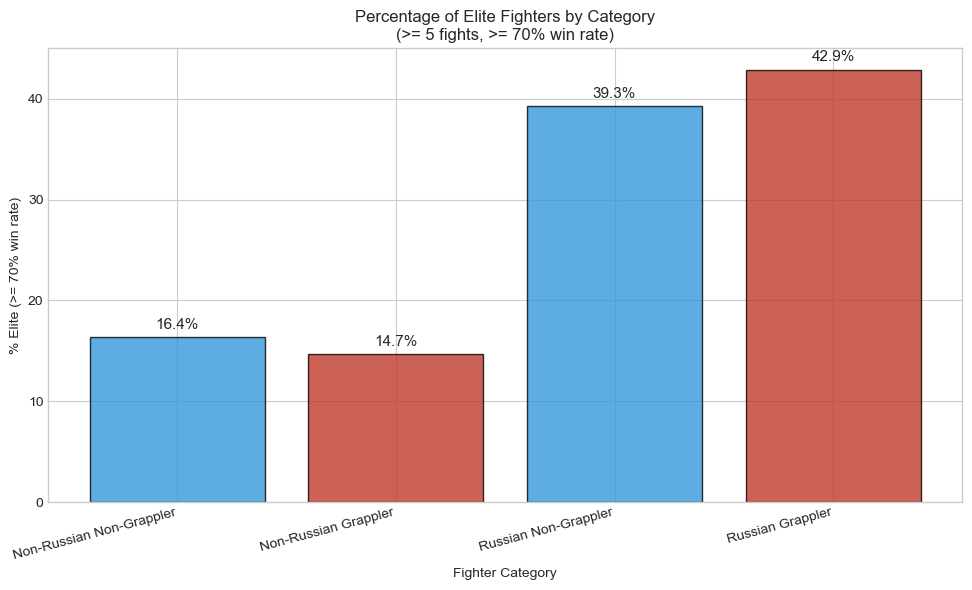

In [27]:
fig, ax = plt.subplots(figsize=(10, 6))

cat_names_elite = elite_percentages.index.tolist()
pct_values = elite_percentages.values

elite_bar_colors = []
for cat in cat_names_elite:
    if 'Russian Grappler' in cat:
        elite_bar_colors.append('#c0392b')
    elif 'Russian' in cat:
        elite_bar_colors.append('#3498db')
    else:
        elite_bar_colors.append('#95a5a6')

bars = ax.bar(cat_names_elite, pct_values, color=elite_bar_colors, edgecolor='black', alpha=0.8)

for bar, pct in zip(bars, pct_values):
    x_pos = bar.get_x() + bar.get_width()/2
    y_pos = bar.get_height() + 0.5
    ax.text(x_pos, y_pos, str(pct) + '%', ha='center', va='bottom', fontsize=11)

ax.set_xlabel('Fighter Category')
ax.set_ylabel('% Elite (>= 70% win rate)')
ax.set_title('Percentage of Elite Fighters by Category\n(>= 5 fights, >= 70% win rate)')
plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.show()

CLEAR INDICATION OF SUCCESS OF RUSSIAN FIGHTERS

Who are these elite Russian grapplers?

In [28]:
elite_rg = elite_fighters[elite_fighters['fighter_category'] == 'Russian Grappler']
elite_rg_sorted = elite_rg.sort_values('wins', ascending=False)

if len(elite_rg_sorted) > 0:
    print("Elite Russian Grapplers:")
    print("=" * 60)
    cols_display = ['name', 'style', 'wins', 'losses', 'win_rate', 'total_fights']
    print(elite_rg_sorted[cols_display].head(15).to_string())

Elite Russian Grapplers:
                     name                style  wins  losses  win_rate  total_fights
0         Islam Makhachev            wrestling    16       1  0.941176            17
1897  Khabib Nurmagomedov            wrestling    13       0  1.000000            13
1761     Mairbek Taisumov  brazilian jiu-jitsu     7       2  0.777778             9
115    Rinat Fakhretdinov            wrestling     6       0  0.857143             7
931       Tagir Ulanbekov            wrestling     6       1  0.857143             7
537       Ikram Aliskerov                sambo     4       1  0.800000             5
